In [1]:
import os
os.environ['LIWC_PATH'] = "data/LIWC.json"
os.environ['OPENBLAS_NUM_THREADS'] = '1'
os.environ['MKL_NUM_THREADS'] = '1'
# os.environ['NUMBA_NUM_THREADS'] = '8'
from os.path import join, dirname
import sys
sys.path.append('../')

from functools import partial

import numpy as np
from scipy import sparse as sp
import numba as nb
from torch.utils.data import DataLoader
from sklearn.preprocessing import StandardScaler, QuantileTransformer

from lyricpsych.utils import (load_csr_data,
                              split_recsys_data,
                              slice_row_sparse,
                              prepare_feature,
                              get_all_comb)
from lyricpsych.tasks.fm import *
from lyricpsych.tasks.als_feat import *
from lyricpsych.tasks.recsys import UserKNN, build_user_profile
from lyricpsych.utils import split_recsys_data, slice_row_sparse
from lyricpsych.metrics import ndcg

from implicit.als import AlternatingLeastSquares
import matplotlib.pyplot as plt
from tqdm import tqdm


def load_data(recsys_data_fn, text_feat_data_fn):
    """"""
    print('Loading data...')
    X, users, items = load_csr_data(recsys_data_fn)
    item_hash_rec_data = {tid:j for j, tid in enumerate(items)}
    feature, track2id, pca, sclr, feature_sets = prepare_feature(text_feat_data_fn)
    
    mutual_tid = [tid for tid in items if tid in track2id]
    ix = [track2id[i] for i in mutual_tid]
    Y = np.concatenate(
        [feat[ix] for k, feat in feature.items()],
        axis=1
    )
    
    sclr = StandardScaler()
    # sclr = QuantileTransformer()
    Y = sclr.fit_transform(Y)
    mut_tid_set = set(mutual_tid)
    targets = [item_hash_rec_data[tid] for tid in mutual_tid]
    X2 = X[:, targets]
    return X2, Y, users, mutual_tid

# Possibilities

1. partial learning of item factor for given seed tags and the feature using ALS
2. hybrid model using NN as the feature encoder and the ALS for other parts
    - 1 iteration:: ALS(user) -> ALS(item) -> ALS(feat>item)
    - issues such as learning time / more parameters
    - potentially better model will be obtained anyway
3. performance?

In [19]:
# HERE WE LOAD DATA
# root = '/home/jaykim/Documents/workbench/lyricpsych/'
# recsys_data_fn = join(root, 'data/recsys_data.h5')
# text_feat_data_fn = join(root, 'data/text_feat_test.h5')
# X, Y, users, items = load_data(recsys_data_fn, text_feat_data_fn)
# Y = Y[:, 240:]
X = sp.load_npz('/home/jaykim/Downloads/top50_msd/labels.npz')
Y = np.load('/home/jaykim/Downloads/top50_msd/mfcc.npy')

print('Splitting the data...')
Xtr, Xvl, Xts = split_recsys_data(X, train_ratio=0.8, valid_ratio=0.1)

Splitting the data...


In [20]:
Xtr = Xtr.T.tocsr()
Xvl = Xvl.T.tocsr()
Xts = Xts.T.tocsr()

In [21]:
# split itemwise
rnd_idx = np.random.permutation(X.shape[1])
train_bound = int(len(rnd_idx) * 0.6)
valid_bound = train_bound + int(len(rnd_idx) * 0.2)

Ytr = Y[rnd_idx[:train_bound]]
Yvl = Y[rnd_idx[train_bound:valid_bound]]
Yts = Y[rnd_idx[valid_bound:]]

Xtrtr = X[:, rnd_idx[:train_bound]]
Xvlvl = X[:, rnd_idx[train_bound:valid_bound]]
Xtsts = X[:, rnd_idx[valid_bound:]]

In [22]:
mf = ALSFeat(32, lmbda=1, l2=1e-4, alpha=10)
mf.fit(Xtr, Y, Xvl, verbose=True)

[vacc=0.1736]: 100%|████████████████████████████| 15/15 [00:34<00:00,  2.31s/it]


In [41]:
scores = []
n_tests = 2000
topk = 5
Xvl_ = Xvl.T.tocsr()
Xtr_ = Xtr.T.tocsr()
for u in np.random.choice(Xvl_.shape[0], n_tests, False):
    true = Xvl_[u].indices
    if len(true) == 0:
        continue
    train = Xtr_[u].indices
    
    s = mf.embeddings_['item'][u] @ mf.embeddings_['user'].T
    s[train] = -np.inf
    idx = np.argpartition(-s, kth=topk)[:topk]
    pred = idx[np.argsort(-s[idx])]
    scores.append(ndcg(true, pred, topk))

np.mean(scores)

0.15369506935138907

In [6]:
mf = ALSFeat(32, lmbda=1, l2=1e-4, alpha=10)
mf.fit(Xtrtr, Ytr, verbose=True)

[vacc=0.0000]: 100%|████████████████████████████| 15/15 [01:45<00:00,  7.01s/it]


In [123]:
from sklearn.neural_network import MLPRegressor

mlp = MLPRegressor((256, 256))
mlp.fit(Ytr[:, 240:], mf.embeddings_['item'])

MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(256, 256), learning_rate='constant',
             learning_rate_init=0.001, max_iter=200, momentum=0.9,
             n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
             random_state=None, shuffle=True, solver='adam', tol=0.0001,
             validation_fraction=0.1, verbose=False, warm_start=False)

In [9]:
X_test = sp.hstack([Xtrtr, Xvlvl]).tocsr()
V = mf.embeddings_['item']
Vvl = Yvl @ mf.embeddings_['feat']
# Vvl = mlp.predict(Yvl[:, 240:])
Vfull = np.concatenate([V, Vvl], axis=0)

In [10]:
scores = []
n_tests = 2000
topk = 100
for u in np.random.choice(X_test.shape[0], n_tests, False):
    pos = X_test[u].indices
    train, true = pos[pos < train_bound], pos[pos >= train_bound]
    if len(true) == 0:
        continue
    s = mf.embeddings_['user'][u] @ Vfull.T
    s[train] = -np.inf
    idx = np.argpartition(-s, kth=topk)[:topk]
    pred = idx[np.argsort(-s[idx])]
    scores.append(ndcg(true, pred, topk))

In [11]:
np.mean(scores)

0.0011740932770829212

In [23]:
U = mf.embeddings_['user']
V = mf.embeddings_['item']
W = mf.embeddings_['feat']
# Y_ = Y[:, 240:]
# L = ((V - Y_ @ W)**2).sum()
# print(L)

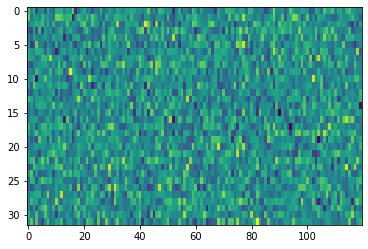

In [26]:
plt.imshow(W.T, aspect='auto')

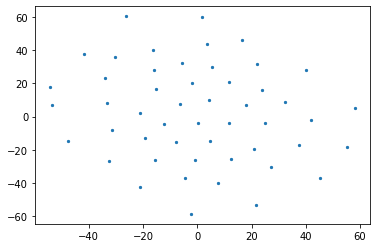

In [31]:
from sklearn.manifold import TSNE

tsne = TSNE(2)
# z2 = tsne.fit_transform(U[np.random.choice(U.shape[0], 3000, False)])
z2 = tsne.fit_transform(U)
plt.scatter(z2[:, 0], z2[:, 1], s=5)

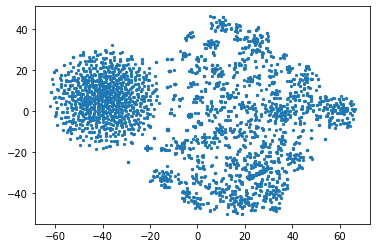

In [28]:
z2 = tsne.fit_transform(V[np.random.choice(V.shape[0], 3000, False)])
plt.scatter(z2[:, 0], z2[:, 1], s=5)

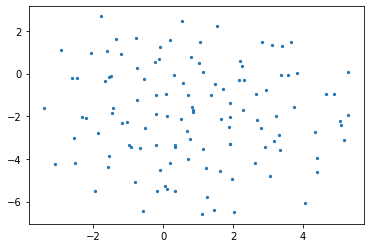

In [29]:
z2 = tsne.fit_transform(W)
plt.scatter(z2[:, 0], z2[:, 1], s=5)